In [137]:
# ============================================
# SECTION 3.1 – DATASET DESCRIPTION AND ANALYSIS
# ============================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configure display
pd.set_option('display.max_columns', 100)
plt.style.use('seaborn-v0_8-whitegrid')

# Load dataset
df = pd.read_csv("AdultIncome.csv")

print("Dataset shape:", df.shape)
df.head()

Dataset shape: (32561, 15)


,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


In [138]:
print("\n--- Data Info ---")
df.info()

# Replace '?' with NaN in the entire DataFrame
df.replace('?', np.nan, inplace=True)

print("\n--- Missing Values ---")
missing = df.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)
missing.head(10)


--- Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education.num   32561 non-null  int64 
 5   marital.status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital.gain    32561 non-null  int64 
 11  capital.loss    32561 non-null  int64 
 12  hours.per.week  32561 non-null  int64 
 13  native.country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB

--- Missing Values ---


occupation        1843
workclass         1836
native.country     583
dtype: int64

In [139]:
# Clean up column names
df.columns = [col.strip().replace(".", "_") for col in df.columns]

# Print 5 columns per row
cols = df.columns.tolist()
for i in range(0, len(cols), 5):
    print(cols[i:i+5])

['age', 'workclass', 'fnlwgt', 'education', 'education_num']
['marital_status', 'occupation', 'relationship', 'race', 'sex']
['capital_gain', 'capital_loss', 'hours_per_week', 'native_country', 'income']


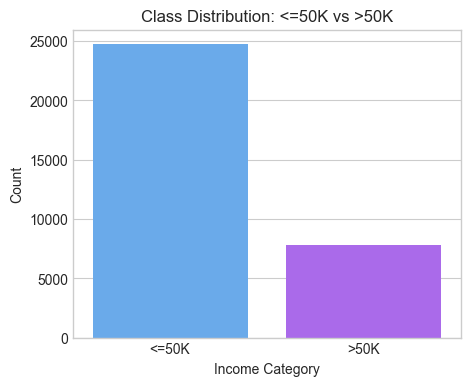

income
<=50K    0.75919
>50K     0.24081
Name: proportion, dtype: float64


In [140]:
plt.figure(figsize=(5,4))
sns.countplot(x='income', hue='income', data=df, palette='cool', legend=False)
plt.title("Class Distribution: <=50K vs >50K")
plt.xlabel("Income Category")
plt.ylabel("Count")
plt.show()

print(df['income'].value_counts(normalize=True))

In [141]:
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print("Numeric features:", numeric_cols)

df[numeric_cols].describe().T

Numeric features: ['age', 'fnlwgt', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']


,count,mean,std,min,25%,50%,75%,max
age,32561.0,38.581647,13.640433,17.0,28.0,37.0,48.0,90.0
fnlwgt,32561.0,189778.366512,105549.977697,12285.0,117827.0,178356.0,237051.0,1484705.0
education_num,32561.0,10.080679,2.572720,1.0,9.0,10.0,12.0,16.0
capital_gain,32561.0,1077.648844,7385.292085,0.0,0.0,0.0,0.0,99999.0
capital_loss,32561.0,87.303830,402.960219,0.0,0.0,0.0,0.0,4356.0
hours_per_week,32561.0,40.437456,12.347429,1.0,40.0,40.0,45.0,99.0


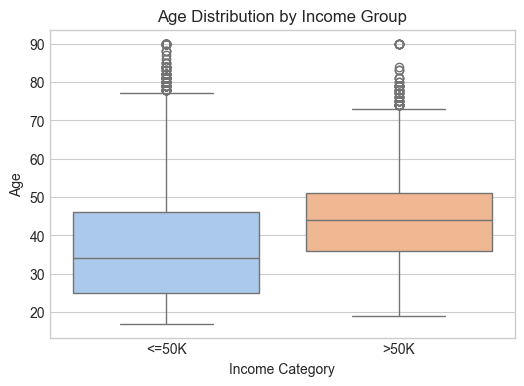

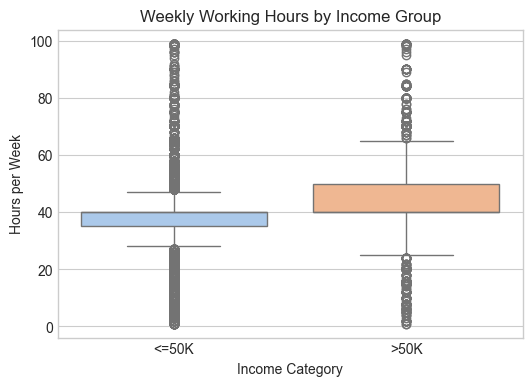

In [142]:
plt.figure(figsize=(6,4))
sns.boxplot(x='income', y='age', hue='income', data=df, palette='pastel', legend=False)
plt.title("Age Distribution by Income Group")
plt.xlabel("Income Category")
plt.ylabel("Age")
plt.show()

plt.figure(figsize=(6,4))
sns.boxplot(x='income', y='hours_per_week', hue='income', data=df, palette='pastel', legend=False)
plt.title("Weekly Working Hours by Income Group")
plt.xlabel("Income Category")
plt.ylabel("Hours per Week")
plt.show()

In [143]:
# ============================================
# SECTION 3.2 – DATA PRE-PROCESSING AND HANDLING IMBALANCE
# ============================================
# Count missing values
print("Missing values per column:")
print(df.isnull().sum()[df.isnull().sum() > 0])

# Drop rows with missing values
df.dropna(inplace=True)
print("\nAfter cleaning, dataset shape:", df.shape)


Missing values per column:
workclass         1836
occupation        1843
native_country     583
dtype: int64

After cleaning, dataset shape: (30162, 15)


In [144]:
from sklearn.preprocessing import LabelEncoder

# Identify categorical columns
cat_cols = df.select_dtypes(exclude=[np.number]).columns.tolist()
print("Categorical columns:", cat_cols)

# Apply label encoding
le = LabelEncoder()
for col in cat_cols:
    df[col] = le.fit_transform(df[col])

print("\nAfter encoding:")
print(df.head())

Categorical columns: ['workclass', 'education', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'native_country', 'income']

After encoding:
   age  workclass  fnlwgt  education  education_num  marital_status  \
1   82          2  132870         11              9               6   
3   54          2  140359          5              4               0   
4   41          2  264663         15             10               5   
5   34          2  216864         11              9               0   
6   38          2  150601          0              6               5   

   occupation  relationship  race  sex  capital_gain  capital_loss  \
1           3             1     4    0             0          4356   
3           6             4     4    0             0          3900   
4           9             3     4    0             0          3900   
5           7             4     4    0             0          3770   
6           0             4     4    1             0          3770 

In [145]:
from sklearn.model_selection import train_test_split

X = df.drop('income', axis=1)
y = df['income']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)
print("Target class distribution (train):", y_train.value_counts(normalize=True))

Train shape: (24129, 14)
Test shape: (6033, 14)
Target class distribution (train): income
0    0.751088
1    0.248912
Name: proportion, dtype: float64


In [146]:
from imblearn.over_sampling import SMOTE

# Apply Synthetic Minority Oversampling Technique (SMOTE)
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("Before resampling:", y_train.value_counts())
print("After resampling:", y_train_resampled.value_counts())

Before resampling: income
0    18123
1     6006
Name: count, dtype: int64
After resampling: income
0    18123
1    18123
Name: count, dtype: int64


In [147]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = X_train_resampled.copy()
X_test_scaled = X_test.copy()

num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()

# Apply scaling only to numeric columns
X_train_scaled[num_cols] = scaler.fit_transform(X_train_resampled[num_cols])
X_test_scaled[num_cols] = scaler.transform(X_test[num_cols])

print("Numeric features scaled successfully.")

Numeric features scaled successfully.


Top correlated features with income:
income            1.000000
education_num     0.335286
age               0.241998
hours_per_week    0.229480
capital_gain      0.221196
sex               0.216699
capital_loss      0.150053
education         0.078987
race              0.071658
occupation        0.051577
Name: income, dtype: float64


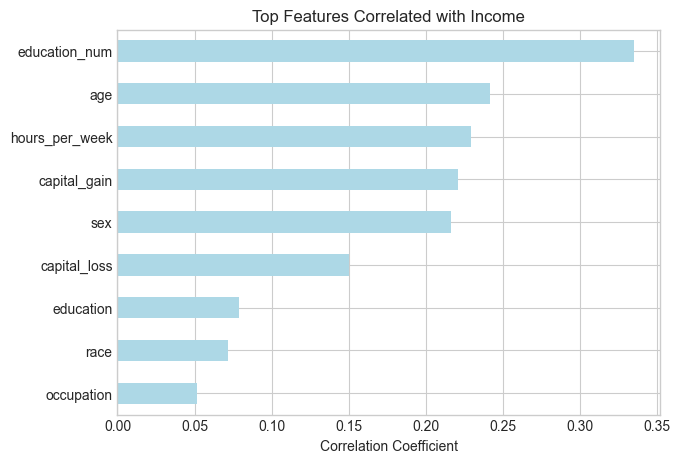

In [148]:
# ============================================
# SECTION 3.3 – FEATURE ENGINEERING
# ============================================

# Compute correlation with target (income)
corr = df.corr()['income'].sort_values(ascending=False)
print("Top correlated features with income:")
print(corr.head(10))

# Visualize correlations with income
plt.figure(figsize=(7,5))
corr.head(10).drop('income').plot(kind='barh', color='lightblue')
plt.title("Top Features Correlated with Income")
plt.xlabel("Correlation Coefficient")
plt.gca().invert_yaxis()
plt.show()

In [149]:
# Create total capital feature
df['total_capital'] = df['capital_gain'] - df['capital_loss']

# Create working_hours_group
df['working_hours_group'] = pd.cut(
    df['hours_per_week'],
    bins=[0, 35, 45, 60, 100],
    labels=['Part-time', 'Full-time', 'Overtime', 'Extreme']
)

# Encode new categorical feature
le = LabelEncoder()
df['working_hours_group'] = le.fit_transform(df['working_hours_group'].astype(str))
print(df[['hours_per_week', 'working_hours_group', 'total_capital']].head())

   hours_per_week  working_hours_group  total_capital
1              18                    3          -4356
3              40                    1          -3900
4              40                    1          -3900
5              45                    1          -3770
6              40                    1          -3770


[LightGBM] [Info] Number of positive: 7508, number of negative: 22654
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000856 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 857
[LightGBM] [Info] Number of data points in the train set: 30162, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.248922 -> initscore=-1.104367
[LightGBM] [Info] Start training from score -1.104367


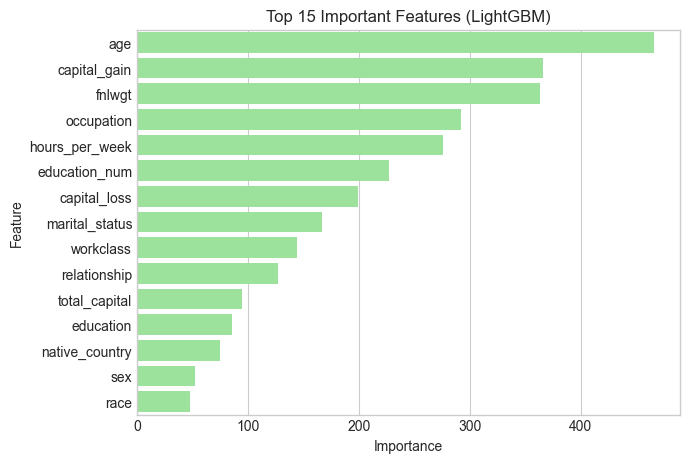

In [150]:
from lightgbm import LGBMClassifier

# Prepare dataset for feature importance evaluation
X = df.drop('income', axis=1)
y = df['income']

model = LGBMClassifier(random_state=42)
model.fit(X, y)

importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)

# Plot top 15 features
plt.figure(figsize=(7,5))
sns.barplot(x=importances.head(15), y=importances.head(15).index, color='lightgreen')
plt.title("Top 15 Important Features (LightGBM)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

In [151]:
# Select top features for model training
selected_features = [
    'education_num', 'capital_gain', 'hours_per_week',
    'age', 'marital_status', 'occupation', 'total_capital'
]

X_selected = df[selected_features]
y = df['income']

print("Selected feature set:", X_selected.columns.tolist())

Selected feature set: ['education_num', 'capital_gain', 'hours_per_week', 'age', 'marital_status', 'occupation', 'total_capital']


In [152]:
# ============================================
# SECTION 3.4 – MODEL IMPLEMENTATION
# ============================================

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Split dataset again using selected features
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.2, random_state=42, stratify=y
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (24129, 7)
Test shape: (6033, 7)


In [153]:
# Train baseline Logistic Regression model
log_model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
log_model.fit(X_train, y_train)

# Predictions
y_pred_log = log_model.predict(X_test)
y_proba_log = log_model.predict_proba(X_test)[:, 1]  # probability for ROC-AUC

# Evaluate metrics
acc_log  = accuracy_score(y_test, y_pred_log)
prec_log = precision_score(y_test, y_pred_log)
rec_log  = recall_score(y_test, y_pred_log)
f1_log   = f1_score(y_test, y_pred_log)
auc_log  = roc_auc_score(y_test, y_proba_log)

print(f"Logistic Regression → Accuracy: {acc_log:.3f}, Precision: {prec_log:.3f}, Recall: {rec_log:.3f}, "
      f"F1: {f1_log:.3f}, ROC-AUC: {auc_log:.3f}")

Logistic Regression → Accuracy: 0.767, Precision: 0.523, Recall: 0.739, F1: 0.612, ROC-AUC: 0.850


In [154]:
# Train tuned LightGBM Classifier
lgb_model = LGBMClassifier(
    n_estimators=400,
    learning_rate=0.05,
    num_leaves=31,
    random_state=42
)
lgb_model.fit(X_train, y_train)

# Predictions
y_pred_lgb = lgb_model.predict(X_test)
y_proba_lgb = lgb_model.predict_proba(X_test)[:, 1]

# Evaluate metrics
acc_lgb  = accuracy_score(y_test, y_pred_lgb)
prec_lgb = precision_score(y_test, y_pred_lgb)
rec_lgb  = recall_score(y_test, y_pred_lgb)
f1_lgb   = f1_score(y_test, y_pred_lgb)
auc_lgb  = roc_auc_score(y_test, y_proba_lgb)

print(f"LightGBM → Accuracy: {acc_lgb:.3f}, Precision: {prec_lgb:.3f}, Recall: {rec_lgb:.3f}, "
      f"F1: {f1_lgb:.3f}, ROC-AUC: {auc_lgb:.3f}")

[LightGBM] [Info] Number of positive: 6006, number of negative: 18123
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000405 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 444
[LightGBM] [Info] Number of data points in the train set: 24129, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.248912 -> initscore=-1.104423
[LightGBM] [Info] Start training from score -1.104423
LightGBM → Accuracy: 0.874, Precision: 0.796, Recall: 0.666, F1: 0.725, ROC-AUC: 0.931


In [155]:
# Combine results into summary table
results_cls = pd.DataFrame({
    'Model': ['Logistic Regression', 'LightGBM Classifier'],
    'Accuracy': [acc_log, acc_lgb],
    'Precision': [prec_log, prec_lgb],
    'Recall': [rec_log, rec_lgb],
    'F1-Score': [f1_log, f1_lgb],
    'ROC-AUC': [auc_log, auc_lgb]
})
print(results_cls)

                 Model  Accuracy  Precision    Recall  F1-Score   ROC-AUC
0  Logistic Regression  0.767114   0.522845  0.739015  0.612414  0.849584
1  LightGBM Classifier  0.874358   0.796178  0.665779  0.725163  0.931388


In [157]:
# ============================================
# SECTION 3.5 – MODEL TUNING AND OPTIMIZATION
# ============================================

from sklearn.model_selection import GridSearchCV

# Parameter grid for Logistic Regression
param_grid_log = {
    'C': [0.01, 0.1, 1, 10],
    'solver': ['lbfgs', 'liblinear'],
    'penalty': ['l2']
}

grid_log = GridSearchCV(
    estimator=LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42),
    param_grid=param_grid_log,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_log.fit(X_train, y_train)

print("Best Logistic Regression parameters:", grid_log.best_params_)
print("Best cross-validated ROC-AUC:", grid_log.best_score_)

# Evaluate tuned model
best_log = grid_log.best_estimator_
y_pred_log_tuned = best_log.predict(X_test)
y_proba_log_tuned = best_log.predict_proba(X_test)[:, 1]

acc_log_tuned  = accuracy_score(y_test, y_pred_log_tuned)
prec_log_tuned = precision_score(y_test, y_pred_log_tuned)
rec_log_tuned  = recall_score(y_test, y_pred_log_tuned)
f1_log_tuned   = f1_score(y_test, y_pred_log_tuned)
auc_log_tuned  = roc_auc_score(y_test, y_proba_log_tuned)

print(f"Tuned Logistic Regression → Accuracy: {acc_log_tuned:.3f}, Precision: {prec_log_tuned:.3f}, "
      f"Recall: {rec_log_tuned:.3f}, F1: {f1_log_tuned:.3f}, ROC-AUC: {auc_log_tuned:.3f}")

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best Logistic Regression parameters: {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
Best cross-validated ROC-AUC: 0.8332288546557995
Tuned Logistic Regression → Accuracy: 0.767, Precision: 0.523, Recall: 0.738, F1: 0.613, ROC-AUC: 0.850


In [158]:
# Parameter grid for LightGBM
param_grid_lgb = {
    'num_leaves': [20, 31, 40],
    'learning_rate': [0.05, 0.1],
    'n_estimators': [200, 400, 600],
    'max_depth': [6, 8, 10]
}

grid_lgb = GridSearchCV(
    estimator=LGBMClassifier(random_state=42),
    param_grid=param_grid_lgb,
    scoring='roc_auc',
    cv=3,
    n_jobs=-1,
    verbose=1
)

grid_lgb.fit(X_train, y_train)

print("Best LightGBM parameters:", grid_lgb.best_params_)
print("Best cross-validated ROC-AUC:", grid_lgb.best_score_)

# Evaluate tuned model
best_lgb_cls = grid_lgb.best_estimator_
y_pred_lgb_tuned = best_lgb_cls.predict(X_test)
y_proba_lgb_tuned = best_lgb_cls.predict_proba(X_test)[:, 1]

acc_lgb_tuned  = accuracy_score(y_test, y_pred_lgb_tuned)
prec_lgb_tuned = precision_score(y_test, y_pred_lgb_tuned)
rec_lgb_tuned  = recall_score(y_test, y_pred_lgb_tuned)
f1_lgb_tuned   = f1_score(y_test, y_pred_lgb_tuned)
auc_lgb_tuned  = roc_auc_score(y_test, y_proba_lgb_tuned)

print(f"Tuned LightGBM → Accuracy: {acc_lgb_tuned:.3f}, Precision: {prec_lgb_tuned:.3f}, "
      f"Recall: {rec_lgb_tuned:.3f}, F1: {f1_lgb_tuned:.3f}, ROC-AUC: {auc_lgb_tuned:.3f}")

Fitting 3 folds for each of 54 candidates, totalling 162 fits
[LightGBM] [Info] Number of positive: 4004, number of negative: 12082
[LightGBM] [Info] Number of positive: 4004, number of negative: 12082
[LightGBM] [Info] Number of positive: 4004, number of negative: 12082
[LightGBM] [Info] Number of positive: 4004, number of negative: 12082
[LightGBM] [Info] Number of positive: 4004, number of negative: 12082
[LightGBM] [Info] Number of positive: 4004, number of negative: 12082
[LightGBM] [Info] Number of positive: 4004, number of negative: 12082
[LightGBM] [Info] Number of positive: 4004, number of negative: 12082
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002696 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002789 seconds.
You can set `force_row_wise=true` to remove the 

In [159]:
results_tuned = pd.DataFrame({
    'Model': ['Logistic Regression (Tuned)', 'LightGBM (Tuned)'],
    'Accuracy': [acc_log_tuned, acc_lgb_tuned],
    'Precision': [prec_log_tuned, prec_lgb_tuned],
    'Recall': [rec_log_tuned, rec_lgb_tuned],
    'F1-Score': [f1_log_tuned, f1_lgb_tuned],
    'ROC-AUC': [auc_log_tuned, auc_lgb_tuned]
})
print(results_tuned)

                         Model  Accuracy  Precision    Recall  F1-Score  \
0  Logistic Regression (Tuned)  0.767446   0.523360  0.738349  0.612538   
1             LightGBM (Tuned)  0.874689   0.805738  0.654461  0.722263   

    ROC-AUC  
0  0.849574  
1  0.932072  
